This notebook is used to postprocessing the inverse modeling results of the cloud chamber model.

In [1]:
# Libraries
from pathlib import Path
import itertools
import pandas as pd
import numpy as np

from kim.map import KIM
from kim.data import Data
from kim.mapping_model import MLP
from kim.utils import plot_sensitivity_mask, plot_sensitivity

import jax

%load_ext autoreload
%autoreload 2
%matplotlib inline 


In [2]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# # define the colors
# cmap = mpl.colors.ListedColormap(['white', 'k'])

# # create a normalize object the describes the limits of
# # each color
# bounds = [-.5, 0.5, 1.5]
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


In [4]:
jax.devices()

10:51:45 INFO:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
10:51:45 INFO:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[CpuDevice(id=0)]

# Files/folders/parameters

In [5]:
dir_case = Path("/people/jian449/KIM/examples/im_cloudmodel")
# Training data
dir_data = dir_case / "data"
f_para = dir_data / "Output_512.csv"
# Saving folder
dir_results = dir_case / "results"


In [6]:
# Locations of the points
# middle_pts = ['s1', 's10', 's19']
# cold_pts = ['s2', 's3', 's9', 's11', 's12', 's18', 's20', 's21', 's27']
# warm_pts = ['s5', 's6', 's7', 's14', 's15', 's16', 's23', 's24', 's25']

# Multiple criteria
# middle_pts_r = [True, False]
# all_ss_varns = [True, False]
# wstd = [True, False]
# wall_types = ['cold', 'warm', 'both']
middle_pts_r = ['mp', 'nompR']
all_ss_varns = ['ss', 'noss']
wstd = ['wstd', 'nowstd']
wall_types = ['cold', 'warm', 'both']

In [7]:
# Get all combinations
combinations = itertools.product(middle_pts_r, all_ss_varns, wstd, wall_types)
label_set, f_state_set, f_kim_set, f_sensi_set = [], [], [], []
for mp, ss, w, wall in combinations:
    label = f'{mp}-{ss}-{w}-{wall}'
    f_state_subset = dir_data / f'Input-{label}.csv'
    f_kim_save = dir_results / f'KIM-{label}'
    f_sensitivity_save = dir_results / f'Data-{label}'

    label_set.append(label)
    f_state_set.append(f_state_subset)
    f_kim_set.append(f_kim_save)
    f_sensi_set.append(f_sensitivity_save)


# Load the results

In [9]:
df_para = pd.read_csv(f_para)
y, y_vars = df_para.values, df_para.keys().to_list()


In [ ]:
# f_data_save = Path("./results/data")
f_data_save = dir_case / "results/data"
data_set, kim_set = [], []
for i,f_state in enumerate(f_state_set):
    label, f_sensi, f_kim = label_set[i], f_sensi_set[i], f_kim_set[i]
    df_state = pd.read_csv(f_state,  index_col=0)
    x = df_state.values
    logging.info(f'Combination: {label}; total number of keys: {x.shape}.')
    # Preliminary analysis result
    data = Data(x, y)
    data.load(f_sensi)
    # Mapping result
    kim = KIM(data, map_configs={}, mask_option="cond_sensitivity", map_option='many2one')
    # Load the trained mappings
    kim.load(f_kim)
    
    kim_set.append(kim)
    data_set.append(data)


10:51:57 INFO:Combination: mp-ss-wstd-cold; total number of keys: (513, 972).
10:52:00 INFO:Combination: mp-ss-wstd-warm; total number of keys: (513, 972).
10:52:02 INFO:Combination: mp-ss-wstd-both; total number of keys: (513, 1458).
10:52:05 INFO:Combination: mp-ss-nowstd-cold; total number of keys: (513, 864).
10:52:07 INFO:Combination: mp-ss-nowstd-warm; total number of keys: (513, 864).
10:52:14 INFO:Combination: mp-ss-nowstd-both; total number of keys: (513, 1296).
10:52:21 INFO:Combination: mp-noss-wstd-cold; total number of keys: (513, 756).
10:52:28 INFO:Combination: mp-noss-wstd-warm; total number of keys: (513, 756).
10:52:34 INFO:Combination: mp-noss-wstd-both; total number of keys: (513, 1134).
10:52:41 INFO:Combination: mp-noss-nowstd-cold; total number of keys: (513, 648).
10:52:47 INFO:Combination: mp-noss-nowstd-warm; total number of keys: (513, 648).
10:52:53 INFO:Combination: mp-noss-nowstd-both; total number of keys: (513, 972).
10:53:00 INFO:Combination: nompR-ss-w

# Post analysis

In [52]:
results = {}
for i,kim in enumerate(kim_set):
    label = label_set[i]
    results[label] = kim.evaluate_maps_on_givendata()

/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/people/jian449/.conda/envs/kim/lib/python3.12/site-packages/hydroeval/objective_functions.py:126: RuntimeWarning: invalid value encountered in divi

## Plot results of one KIM

In [ ]:
# train_or_test = 'test'
# fig, axes = plt.subplots(2,3,figsize=(15,10))
# for i in range(2):
#     y_var = y_vars[i]
#     for j in range(3):
#         model = labels[j]
#         r = results[model]
#         ax = axes[i,j]
#         x = r['true'][train_or_test][...,i]
#         y = r['weighted mean predict'][train_or_test][...,i]
#         yens = r['ens predict'][train_or_test][...,i]
#         w = r['weights'][...,i]
#         std = np.sqrt(np.average((yens-y)**2, weights=w, axis=0))
#         ax.errorbar(x, y, std, color='black', linestyle='None', fmt='o', markersize=2, capsize=2)
#         lim = ax.get_ylim()
#         ax.plot(lim, lim, '--', color='tab:blue')
#         ax.set(xlim=lim, ylim=lim, xlabel='True', ylabel='Prediction', title=f"{model}: {y_var}")


## Impact of subsetting

In [56]:
train_or_test = 'test'
stats = []
for i,y in enumerate(y_vars):
    stats_y = []
    for label in label_set:
        r = results[label]
        metrics = [r['weighted bias'][train_or_test][i], r['weighted relative uncertainty'][train_or_test][i]]
        stats_y.append(metrics+label.split('-'))
    df = pd.DataFrame(stats_y, columns=['bias', 'uncertainty', 'mp', 'ss', 'wstd', 'wall'])
    stats.append(df)

In [57]:
df[df['ss']=='ss']

,bias,uncertainty,mp,ss,wstd,wall
0,0.066908,0.026121,mp,ss,wstd,cold
1,0.083736,0.051073,mp,ss,wstd,warm
2,0.063768,0.037685,mp,ss,wstd,both
3,0.062274,0.015121,mp,ss,nowstd,cold
4,0.091531,0.042761,mp,ss,nowstd,warm
5,0.060934,0.032101,mp,ss,nowstd,both
12,0.068609,0.029918,nompR,ss,wstd,cold
13,0.062600,0.021710,nompR,ss,wstd,warm
14,0.062060,0.039571,nompR,ss,wstd,both
15,0.063750,0.026068,nompR,ss,nowstd,cold


[Text(0.5, 1.0, 'log10(lambda_c)')]

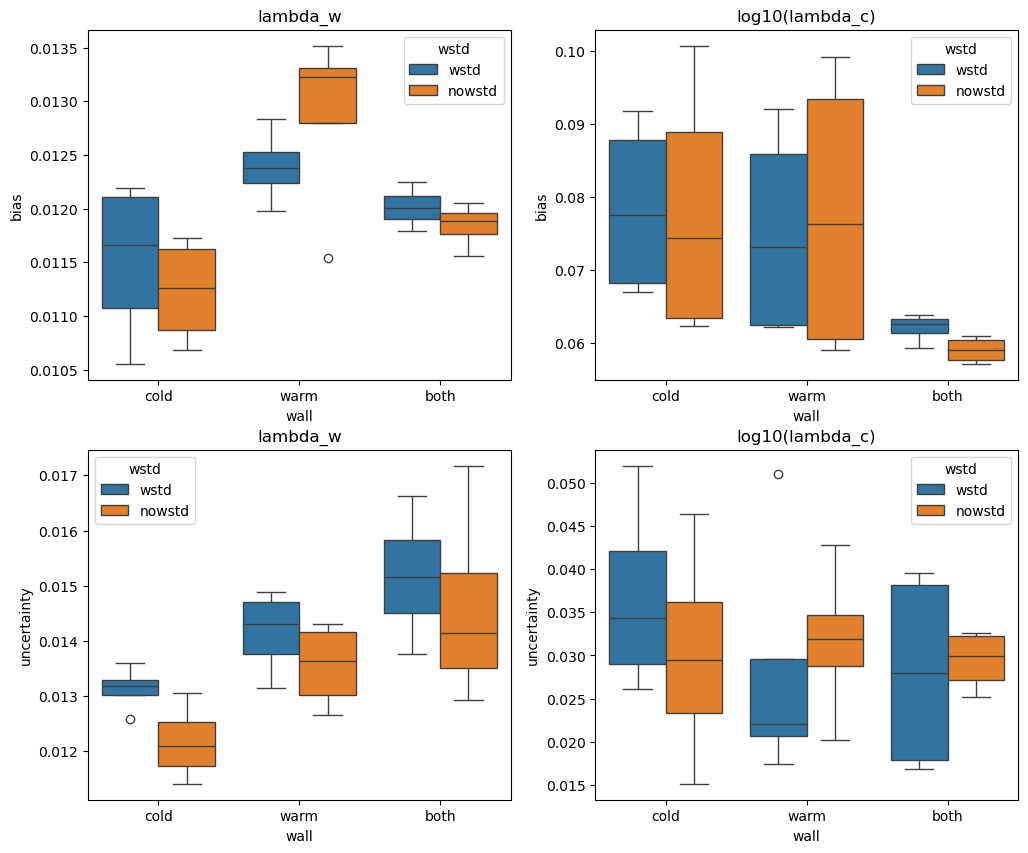

In [67]:
i = 1
x, hue = 'wall', 'wstd'
fig, axes = plt.subplots(2, 2, figsize=(12,10), sharey=False)
sns.boxplot(data=stats[0], x=x, y='bias', hue=hue, ax=axes[0,0])
sns.boxplot(data=stats[1], x=x, y='bias', hue=hue, ax=axes[0,1])
sns.boxplot(data=stats[0], x=x, y='uncertainty', hue=hue, ax=axes[1,0])
sns.boxplot(data=stats[1], x=x, y='uncertainty', hue=hue, ax=axes[1,1])
axes[0,0].set(title=y_vars[0]); axes[0,1].set(title=y_vars[1])
axes[1,0].set(title=y_vars[0]); axes[1,1].set(title=y_vars[1])
# plt.suptitle(y_vars[i])


In [76]:
stats[1]

,bias,uncertainty,mp,ss,wstd,wall
0,0.066908,0.026121,mp,ss,wstd,cold
1,0.083736,0.051073,mp,ss,wstd,warm
2,0.063768,0.037685,mp,ss,wstd,both
3,0.062274,0.015121,mp,ss,nowstd,cold
4,0.091531,0.042761,mp,ss,nowstd,warm
5,0.060934,0.032101,mp,ss,nowstd,both
6,0.086423,0.038743,mp,noss,wstd,cold
7,0.092087,0.022461,mp,noss,wstd,warm
8,0.063182,0.018248,mp,noss,wstd,both
9,0.084870,0.032803,mp,noss,nowstd,cold


## Prediction versus true

/tmp/ipykernel_31385/4194660411.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


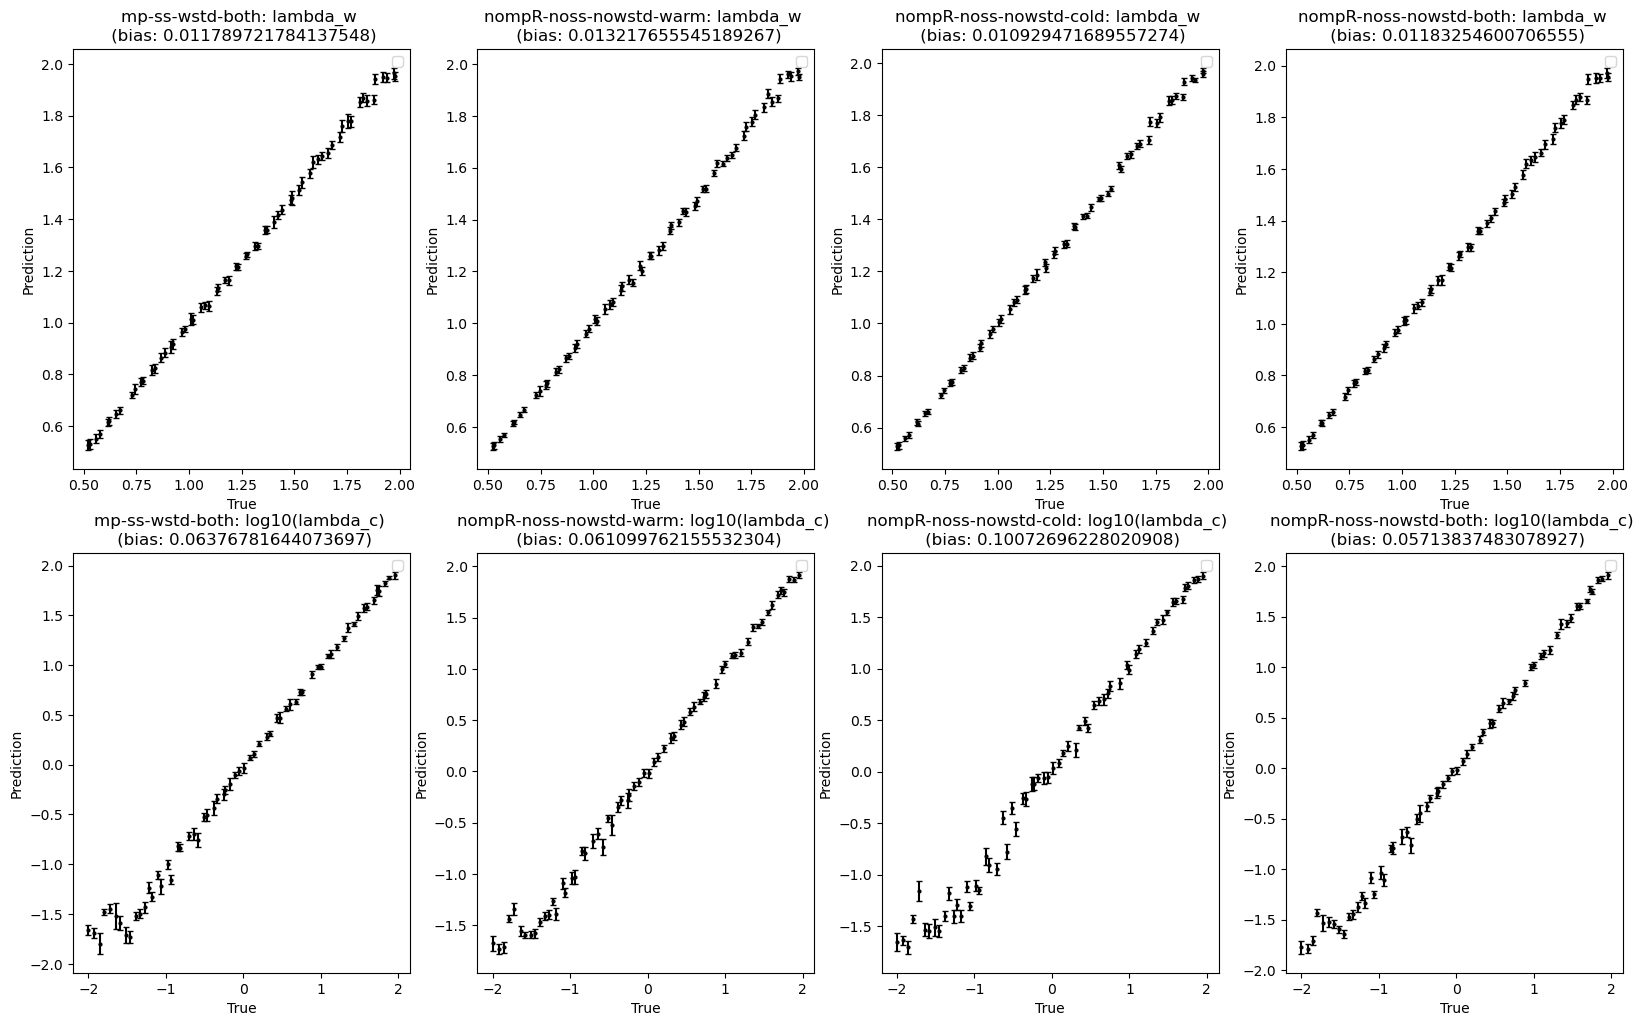

In [75]:
train_or_test = 'test'
# label_set_plot = ['nompR-noss-nowstd-cold', 'nompR-ss-nowstd-warm', 'nompR-ss-nowstd-both', 'nompR-noss-nowstd-cold']
label_set_plot = ['mp-ss-wstd-both', 'nompR-noss-nowstd-warm', 'nompR-noss-nowstd-cold', 'nompR-noss-nowstd-both']
fig, axes = plt.subplots(2,len(label_set_plot),figsize=(20,12))
for i in range(2):
    y_var = y_vars[i]
    for j,model in enumerate(label_set_plot):
        kim = kim_set[j]
        r = results[model]
        ax = axes[i,j]
        # for k in range(100):
        #     ax.scatter(r['true'][train_or_test][...,i], r['ens predict'][train_or_test][k,...,i], 
        #                color='lightgrey', label='ensemble' if k ==0 else None)
        # ax.scatter(r['true'][train_or_test][...,i], r['weighted mean predict'][train_or_test][...,i], 
        #            color='black', label='weighted mean')
        x = r['true'][train_or_test][...,i]
        y = r['weighted mean predict'][train_or_test][...,i]
        std = r['weighted std predict'][train_or_test][...,i]
        bias = r['weighted bias'][train_or_test][i]
        ax.errorbar(x, y, std, color='black', linestyle='None', fmt='o', markersize=2, capsize=2)
        ax.set(xlabel='True', ylabel='Prediction', title=f"{model}: {y_var} \n (bias: {bias})")
        ax.legend()
